<a href="https://colab.research.google.com/github/IO-W/ML_FINAL_3/blob/main/KR_MH_wer_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Biblioteki

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Dane:
- wczytanie
- preprocessing

In [4]:
df = pd.read_csv('dane_KR_MH_IOW.csv')
df.head(5)

,Zlecenie,Matryca,Nr_podejścia,Nr_próbki,Wielkość_podejścia_szt,Kat_Pkt_1,Szerokość_mm_Pkt_1,Kat_Pkt_2,Szerokość_mm_Pkt_2,Kat_Pkt_3,Szerokość_mm_Pkt_3
0,446/2024,Y41,1,1,200.0,35.62,8.52,36.47,8.40,35.50,8.55
1,446/2024,Y41,1,2,200.0,36.14,8.52,36.65,8.41,35.89,8.49
2,446/2024,Y41,1,3,200.0,35.88,8.51,36.66,8.42,35.63,8.51
3,446/2024,Y41,1,4,200.0,35.83,8.51,36.20,8.41,35.25,8.53
4,446/2024,Y41,1,5,200.0,35.54,8.52,36.20,8.44,35.51,8.54


## Analiza braków

Liczba braków w danych:
 Zlecenie                   0
Matryca                    0
Nr_podejścia               0
Nr_próbki                  0
Wielkość_podejścia_szt     2
Kat_Pkt_1                 64
Szerokość_mm_Pkt_1        64
Kat_Pkt_2                 64
Szerokość_mm_Pkt_2        64
Kat_Pkt_3                 70
Szerokość_mm_Pkt_3        70
dtype: int64


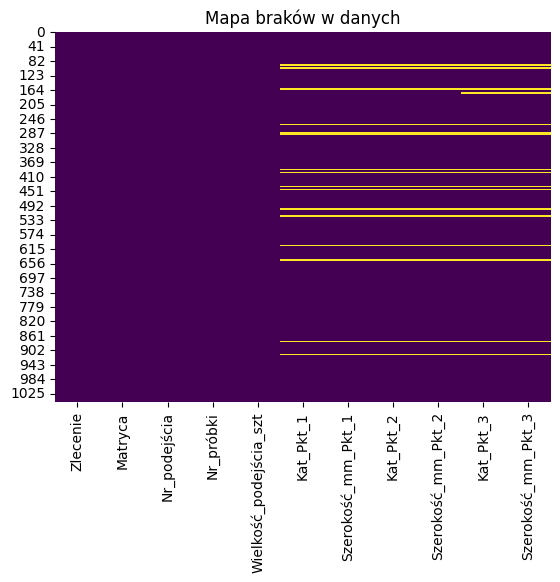

In [5]:
# Analiza liczby braków dla każdej kolumny
missing_summary = df.isna().sum()
print("Liczba braków w danych:\n", missing_summary)

# Wizualizacja braków
sns.heatmap(df.isna(), cbar=False, cmap='viridis')
plt.title('Mapa braków w danych')
plt.show()


In [6]:
df.shape

(1048, 11)

In [7]:
df.dropna(inplace=True)

In [8]:
df.shape

(978, 11)

## Korelacje między zmiennymi

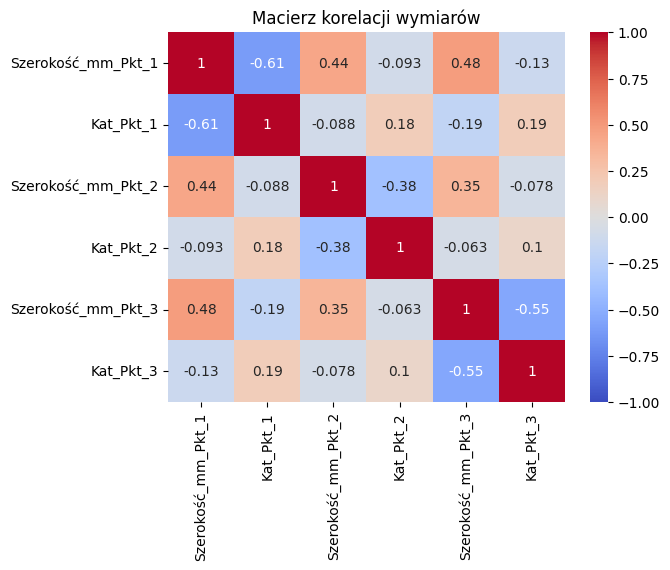

In [9]:
# Korelacje
correlation_matrix = df[['Szerokość_mm_Pkt_1', 'Kat_Pkt_1', 'Szerokość_mm_Pkt_2', 'Kat_Pkt_2', 'Szerokość_mm_Pkt_3', 'Kat_Pkt_3']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Macierz korelacji wymiarów')
plt.show()


## Pytanie 1
Czy nie jest dość dziwne, że korelacja pomiędzy szerokością a kątem jest niewielka? i to samo między punktami?

## Rozkład szerokości i kątów

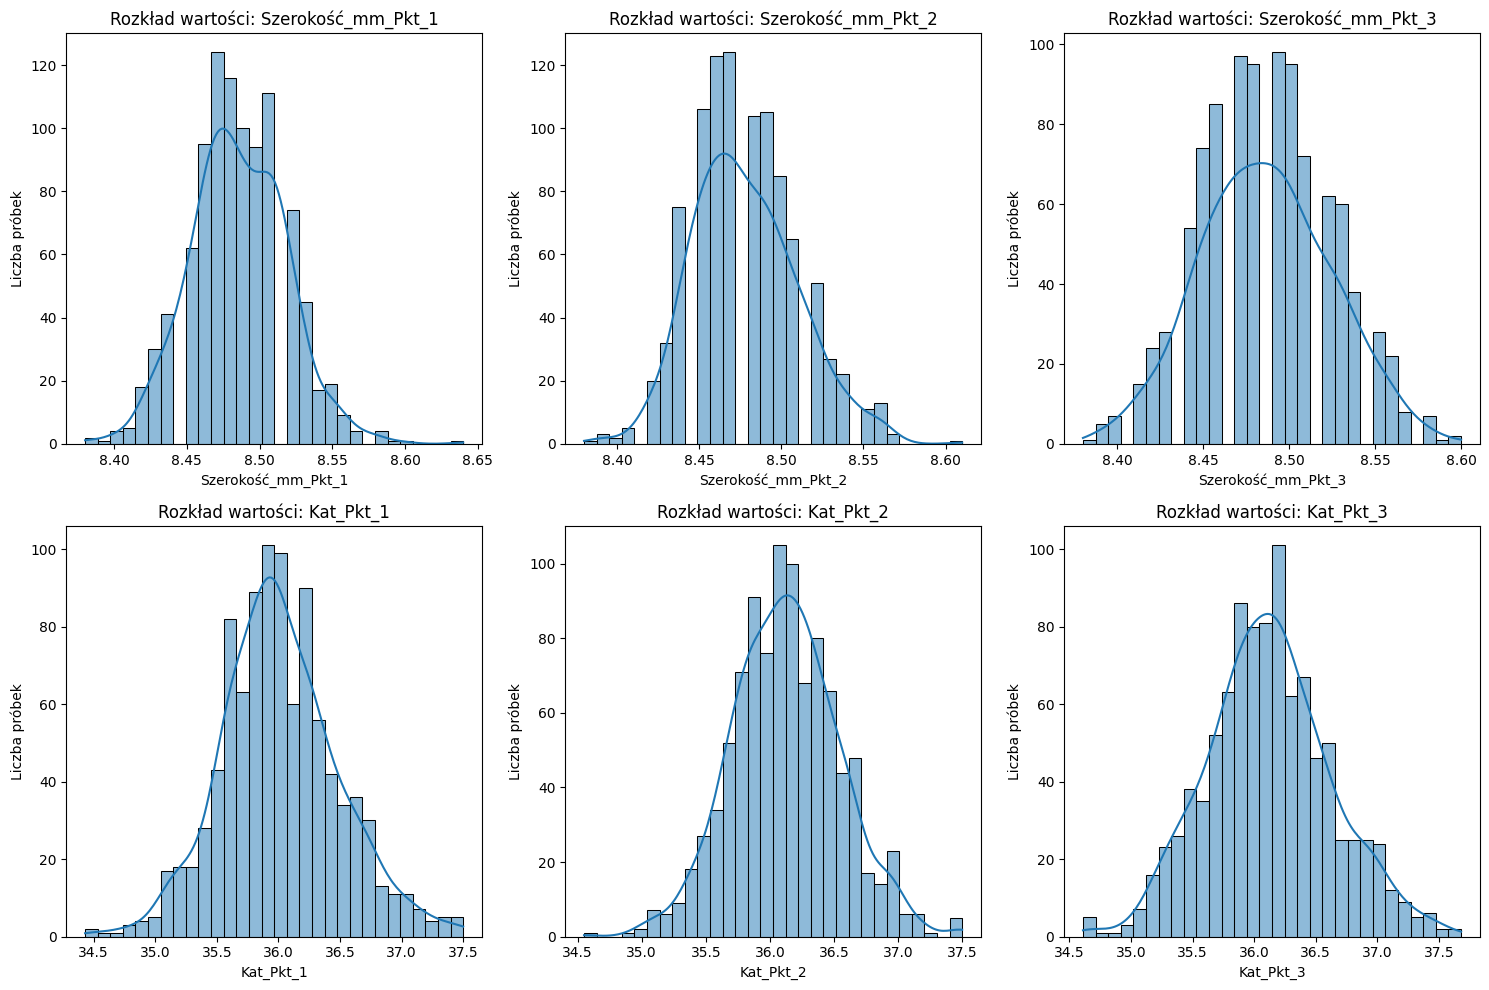

In [10]:
#Rozkłady szerokości i kąta dla punktów 1, 2 i 3
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i, col in enumerate(['Szerokość_mm_Pkt_1', 'Szerokość_mm_Pkt_2', 'Szerokość_mm_Pkt_3', 'Kat_Pkt_1', 'Kat_Pkt_2', 'Kat_Pkt_3']):
    row, col_idx = divmod(i, 3)
    sns.histplot(df[col].dropna(), kde=True, bins=30, ax=axs[row, col_idx])
    axs[row, col_idx].set_title(f'Rozkład wartości: {col}')
    axs[row, col_idx].set_xlabel(col)
    axs[row, col_idx].set_ylabel('Liczba próbek')

plt.tight_layout()
plt.show()


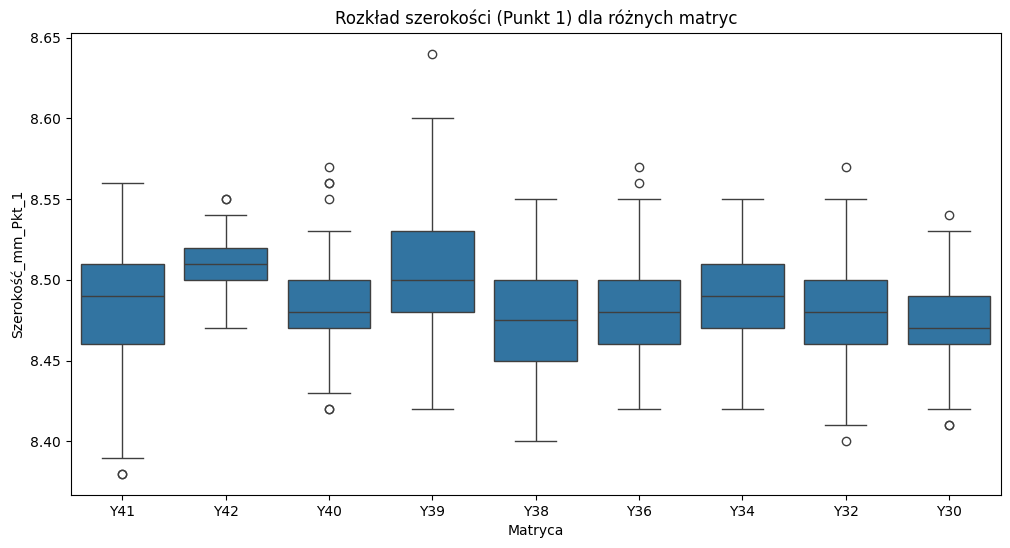

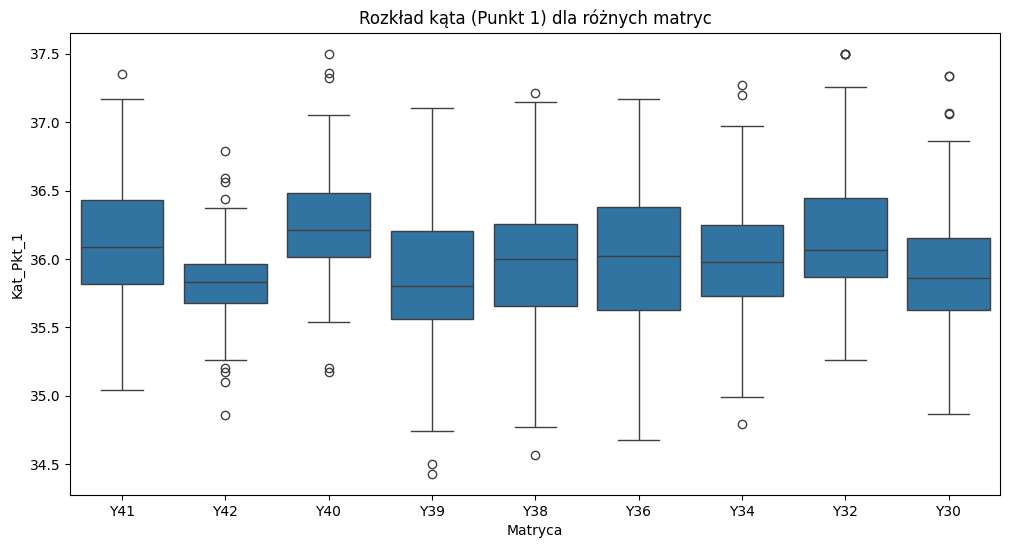

In [11]:
# Wykres pudełkowy dla wymiarów
plt.figure(figsize=(12, 6))
sns.boxplot(x='Matryca', y='Szerokość_mm_Pkt_1', data=df)
plt.title('Rozkład szerokości (Punkt 1) dla różnych matryc')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='Matryca', y='Kat_Pkt_1', data=df)
plt.title('Rozkład kąta (Punkt 1) dla różnych matryc')
plt.show()


## Tolerancje w punkcie 1

## Tolerancje w % dla każdego punktu punktach dla poszczeólnych matryc

<ipython-input-12-1a6a77ea5685>:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i - 1].set_xticklabels(tolerance_summary[punkt].index, rotation=45)
<ipython-input-12-1a6a77ea5685>:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i - 1].set_xticklabels(tolerance_summary[punkt].index, rotation=45)
<ipython-input-12-1a6a77ea5685>:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i - 1].set_xticklabels(tolerance_summary[punkt].index, rotation=45)


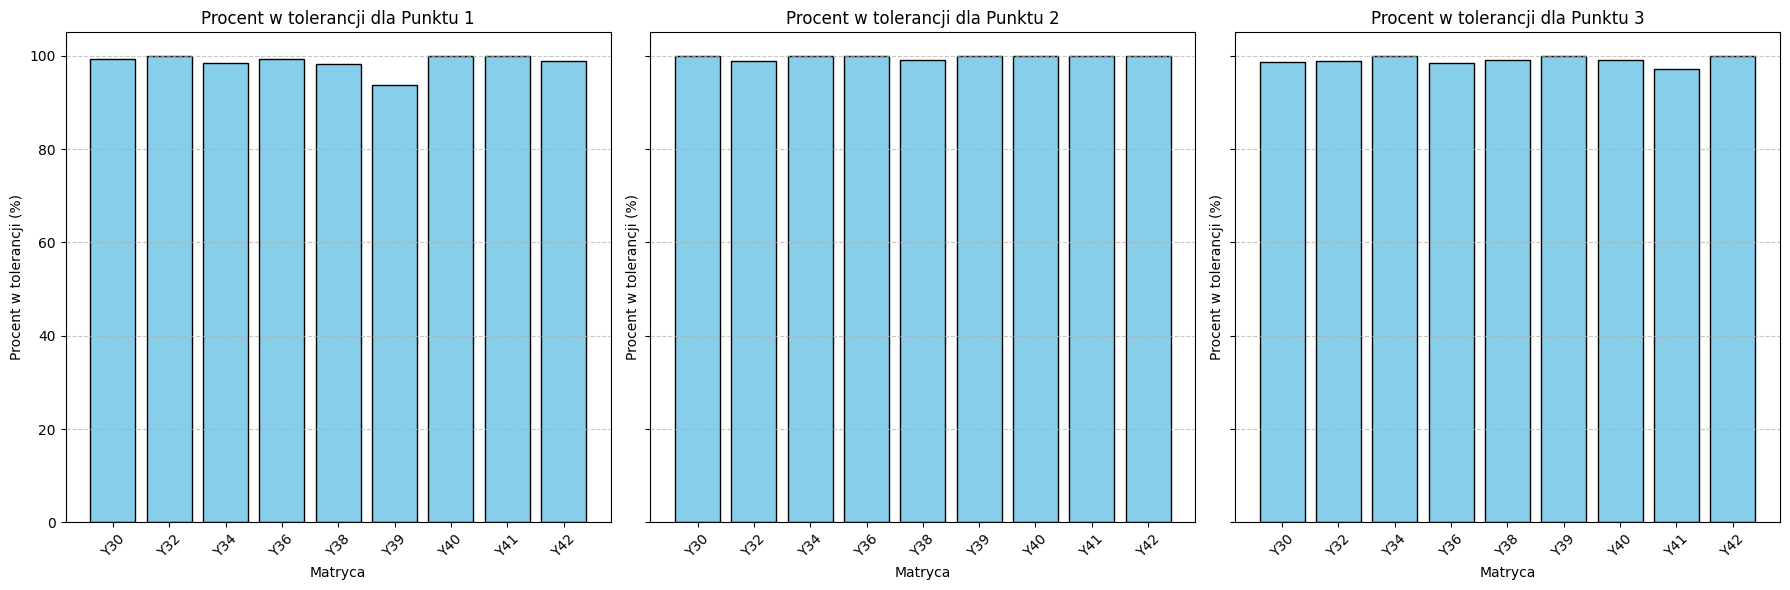

In [12]:
# Funkcja sprawdzająca tolerancję dla dowolnego punktu
def check_tolerances(row, punkt):
    szer_col = f'Szerokość_mm_Pkt_{punkt}'
    kat_col = f'Kat_Pkt_{punkt}'
    szer_in_tolerance = 8.52 - 0.15 <= row[szer_col] <= 8.52 + 0.15
    kat_in_tolerance = 37 - 2 <= row[kat_col] <= 37 + 2
    return szer_in_tolerance and kat_in_tolerance

# Dodanie kolumn w_tol dla każdego punktu
for punkt in range(1, 4):
    df[f'w_tol_Pkt_{punkt}'] = df.apply(check_tolerances, axis=1, punkt=punkt)

# Podsumowanie tolerancji dla każdego punktu i matrycy
tolerance_summary = {}
for punkt in range(1, 4):
    col = f'w_tol_Pkt_{punkt}'
    tolerance_summary[punkt] = df.groupby('Matryca')[col].mean() * 100


# print("Procent odkuwek w tolerancji dla każdej matrycy:")
# print(tolerance_summary)

# Wykresy słupkowe dla każdego punktu
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
for i, punkt in enumerate(tolerance_summary, 1):
    axs[i - 1].bar(tolerance_summary[punkt].index, tolerance_summary[punkt].values, color='skyblue', edgecolor='black')
    axs[i - 1].set_title(f'Procent w tolerancji dla Punktu {punkt}')
    axs[i - 1].set_xlabel('Matryca')
    axs[i - 1].set_ylabel('Procent w tolerancji (%)')
    axs[i - 1].set_xticklabels(tolerance_summary[punkt].index, rotation=45)
    axs[i - 1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [13]:
df['w_tol_Pkt_1'].value_counts()

,count
w_tol_Pkt_1,
True,965
False,13


In [14]:
df['w_tol_Pkt_2'].value_counts()

,count
w_tol_Pkt_2,
True,976
False,2


In [15]:
df['w_tol_Pkt_3'].value_counts()

,count
w_tol_Pkt_3,
True,969
False,9


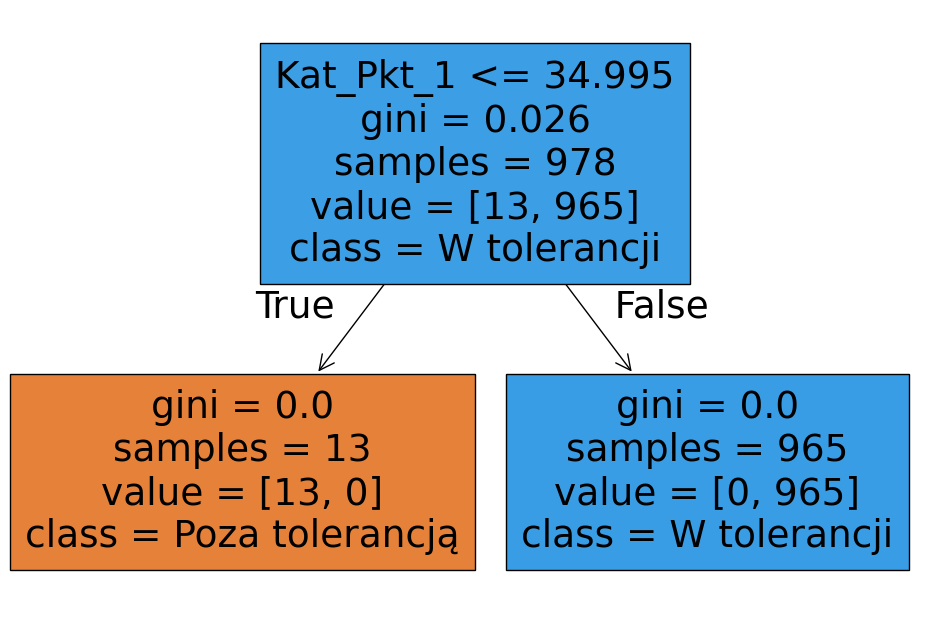

In [16]:
# 5. Analiza jakości produkcji (drzewo decyzyjne)
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Przygotowanie danych do drzewa decyzyjnego
X = df[['Szerokość_mm_Pkt_1', 'Kat_Pkt_1']]
y = df['w_tol_Pkt_1']

model = DecisionTreeClassifier(max_depth=3, random_state=1)
model.fit(X, y)

# Wizualizacja drzewa decyzyjnego
plt.figure(figsize=(12, 8))
plot_tree(model, feature_names=['Szerokość_mm_Pkt_1', 'Kat_Pkt_1'], class_names=['Poza tolerancją', 'W tolerancji'], filled=True)
plt.show()

In [17]:
df.columns

Index(['Zlecenie', 'Matryca', 'Nr_podejścia', 'Nr_próbki',
       'Wielkość_podejścia_szt', 'Kat_Pkt_1', 'Szerokość_mm_Pkt_1',
       'Kat_Pkt_2', 'Szerokość_mm_Pkt_2', 'Kat_Pkt_3', 'Szerokość_mm_Pkt_3',
       'w_tol_Pkt_1', 'w_tol_Pkt_2', 'w_tol_Pkt_3'],
      dtype='object')

# Analiza zlecenia nr 446/2024

# Matryca Y41 / Punkt 1

In [19]:
filtered_data1 = df[(df['Zlecenie'] == '446/2024') & (df['Nr_podejścia'] == 1) & (df['Matryca'] == 'Y41')]
filtered_data2 = df[(df['Zlecenie'] == '446/2024') & (df['Nr_podejścia'] == 2) & (df['Matryca'] == 'Y41')]
filtered_data3 = df[(df['Zlecenie'] == '446/2024') & (df['Nr_podejścia'] == 3) & (df['Matryca'] == 'Y41')]
filtered_data4 = df[(df['Zlecenie'] == '446/2024') & (df['Nr_podejścia'] == 4) & (df['Matryca'] == 'Y41')]
filtered_data5 = df[(df['Zlecenie'] == '446/2024') & (df['Nr_podejścia'] == 5) & (df['Matryca'] == 'Y41')]
filtered_data6 = df[(df['Zlecenie'] == '446/2024') & (df['Nr_podejścia'] == 6) & (df['Matryca'] == 'Y41')]
filtered_data7 = df[(df['Zlecenie'] == '446/2024') & (df['Nr_podejścia'] == 7) & (df['Matryca'] == 'Y41')]
filtered_data8 = df[(df['Zlecenie'] == '446/2024') & (df['Nr_podejścia'] == 8) & (df['Matryca'] == 'Y41')]
filtered_data9 = df[(df['Zlecenie'] == '446/2024') & (df['Nr_podejścia'] == 9) & (df['Matryca'] == 'Y41')]

### Szerokość pkt. 1

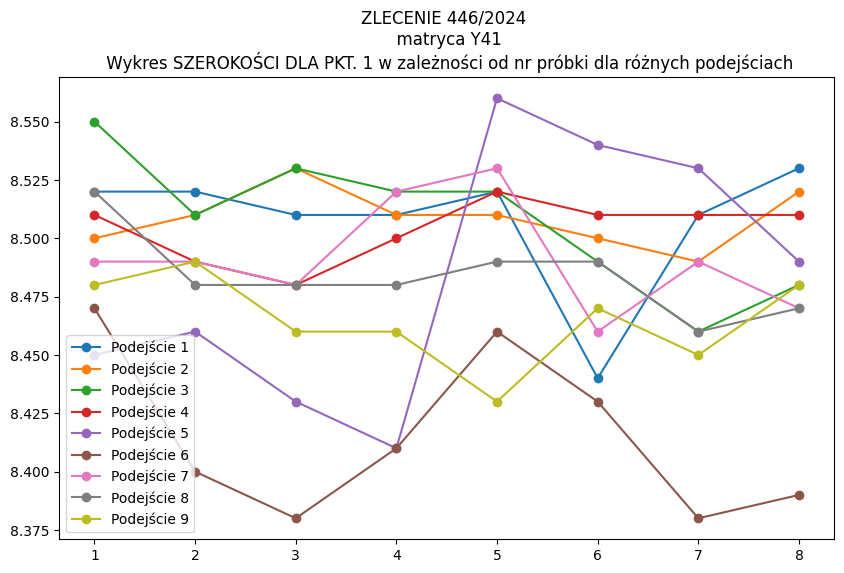

In [20]:
plt.figure(figsize=(10, 6))

plt.plot(filtered_data1['Nr_próbki'], filtered_data1['Szerokość_mm_Pkt_1'], marker='o', label='Podejście 1')
plt.plot(filtered_data2['Nr_próbki'], filtered_data2['Szerokość_mm_Pkt_1'], marker='o', label='Podejście 2')
plt.plot(filtered_data3['Nr_próbki'], filtered_data3['Szerokość_mm_Pkt_1'], marker='o', label='Podejście 3')
plt.plot(filtered_data4['Nr_próbki'], filtered_data4['Szerokość_mm_Pkt_1'], marker='o', label='Podejście 4')
plt.plot(filtered_data5['Nr_próbki'], filtered_data5['Szerokość_mm_Pkt_1'], marker='o', label='Podejście 5')
plt.plot(filtered_data6['Nr_próbki'], filtered_data6['Szerokość_mm_Pkt_1'], marker='o', label='Podejście 6')
plt.plot(filtered_data7['Nr_próbki'], filtered_data7['Szerokość_mm_Pkt_1'], marker='o', label='Podejście 7')
plt.plot(filtered_data8['Nr_próbki'], filtered_data8['Szerokość_mm_Pkt_1'], marker='o', label='Podejście 8')
plt.plot(filtered_data9['Nr_próbki'], filtered_data9['Szerokość_mm_Pkt_1'], marker='o', label='Podejście 9')

# Dodaje legendę
plt.legend()

# Dodaje tytuł
plt.title('ZLECENIE 446/2024 \n  matryca Y41 \n Wykres SZEROKOŚCI DLA PKT. 1 w zależności od nr próbki dla różnych podejściach')

# Wyświetlam wykres
plt.show()

### Szerokość pkt. 2

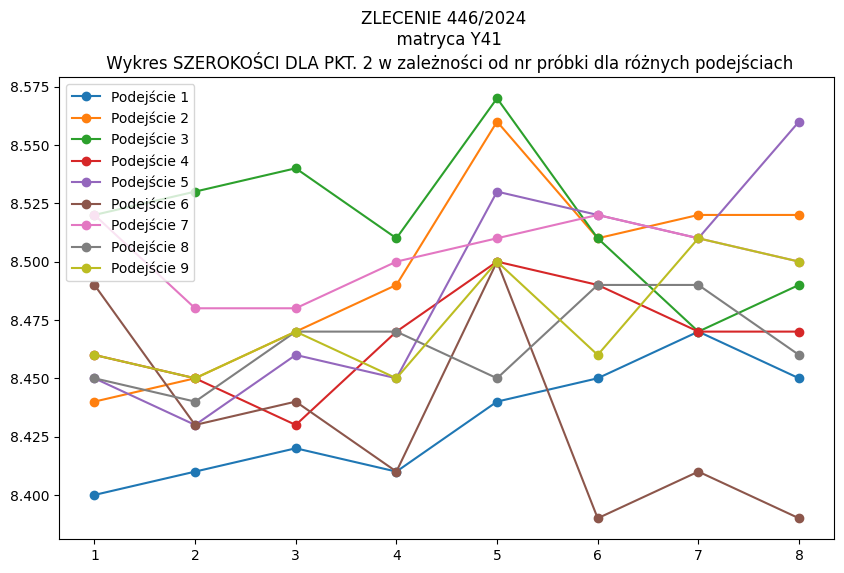

In [21]:
plt.figure(figsize=(10, 6))

plt.plot(filtered_data1['Nr_próbki'], filtered_data1['Szerokość_mm_Pkt_2'], marker='o', label='Podejście 1')
plt.plot(filtered_data2['Nr_próbki'], filtered_data2['Szerokość_mm_Pkt_2'], marker='o', label='Podejście 2')
plt.plot(filtered_data3['Nr_próbki'], filtered_data3['Szerokość_mm_Pkt_2'], marker='o', label='Podejście 3')
plt.plot(filtered_data4['Nr_próbki'], filtered_data4['Szerokość_mm_Pkt_2'], marker='o', label='Podejście 4')
plt.plot(filtered_data5['Nr_próbki'], filtered_data5['Szerokość_mm_Pkt_2'], marker='o', label='Podejście 5')
plt.plot(filtered_data6['Nr_próbki'], filtered_data6['Szerokość_mm_Pkt_2'], marker='o', label='Podejście 6')
plt.plot(filtered_data7['Nr_próbki'], filtered_data7['Szerokość_mm_Pkt_2'], marker='o', label='Podejście 7')
plt.plot(filtered_data8['Nr_próbki'], filtered_data8['Szerokość_mm_Pkt_2'], marker='o', label='Podejście 8')
plt.plot(filtered_data9['Nr_próbki'], filtered_data9['Szerokość_mm_Pkt_2'], marker='o', label='Podejście 9')

# Dodaje legendę
plt.legend()

# Dodaje tytuł
plt.title('ZLECENIE 446/2024 \n  matryca Y41 \n Wykres SZEROKOŚCI DLA PKT. 2 w zależności od nr próbki dla różnych podejściach')

# Wyświetlam wykres
plt.show()

### Szerokość pkt. 3

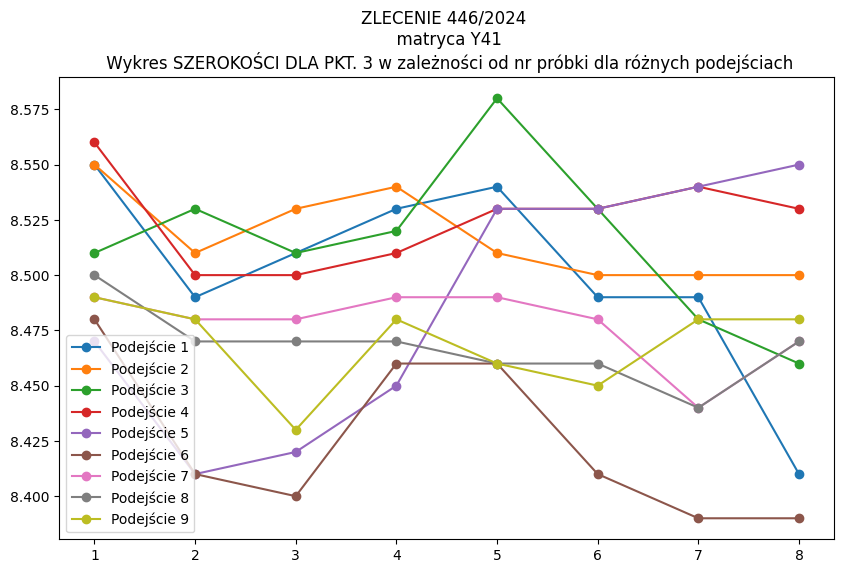

In [22]:
plt.figure(figsize=(10, 6))

plt.plot(filtered_data1['Nr_próbki'], filtered_data1['Szerokość_mm_Pkt_3'], marker='o', label='Podejście 1')
plt.plot(filtered_data2['Nr_próbki'], filtered_data2['Szerokość_mm_Pkt_3'], marker='o', label='Podejście 2')
plt.plot(filtered_data3['Nr_próbki'], filtered_data3['Szerokość_mm_Pkt_3'], marker='o', label='Podejście 3')
plt.plot(filtered_data4['Nr_próbki'], filtered_data4['Szerokość_mm_Pkt_3'], marker='o', label='Podejście 4')
plt.plot(filtered_data5['Nr_próbki'], filtered_data5['Szerokość_mm_Pkt_3'], marker='o', label='Podejście 5')
plt.plot(filtered_data6['Nr_próbki'], filtered_data6['Szerokość_mm_Pkt_3'], marker='o', label='Podejście 6')
plt.plot(filtered_data7['Nr_próbki'], filtered_data7['Szerokość_mm_Pkt_3'], marker='o', label='Podejście 7')
plt.plot(filtered_data8['Nr_próbki'], filtered_data8['Szerokość_mm_Pkt_3'], marker='o', label='Podejście 8')
plt.plot(filtered_data9['Nr_próbki'], filtered_data9['Szerokość_mm_Pkt_3'], marker='o', label='Podejście 9')

# Dodaje legendę
plt.legend()

# Dodaje tytuł
plt.title('ZLECENIE 446/2024 \n  matryca Y41 \n Wykres SZEROKOŚCI DLA PKT. 3 w zależności od nr próbki dla różnych podejściach')

# Wyświetlam wykres
plt.show()

### Kąt pkt. 1

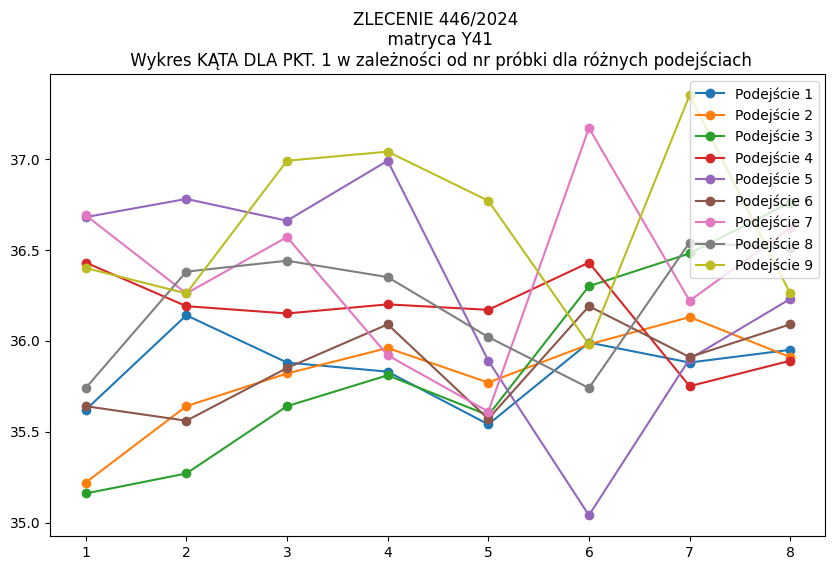

In [23]:
plt.figure(figsize=(10, 6))

plt.plot(filtered_data1['Nr_próbki'], filtered_data1['Kat_Pkt_1'], marker='o', label='Podejście 1')
plt.plot(filtered_data2['Nr_próbki'], filtered_data2['Kat_Pkt_1'], marker='o', label='Podejście 2')
plt.plot(filtered_data3['Nr_próbki'], filtered_data3['Kat_Pkt_1'], marker='o', label='Podejście 3')
plt.plot(filtered_data4['Nr_próbki'], filtered_data4['Kat_Pkt_1'], marker='o', label='Podejście 4')
plt.plot(filtered_data5['Nr_próbki'], filtered_data5['Kat_Pkt_1'], marker='o', label='Podejście 5')
plt.plot(filtered_data6['Nr_próbki'], filtered_data6['Kat_Pkt_1'], marker='o', label='Podejście 6')
plt.plot(filtered_data7['Nr_próbki'], filtered_data7['Kat_Pkt_1'], marker='o', label='Podejście 7')
plt.plot(filtered_data8['Nr_próbki'], filtered_data8['Kat_Pkt_1'], marker='o', label='Podejście 8')
plt.plot(filtered_data9['Nr_próbki'], filtered_data9['Kat_Pkt_1'], marker='o', label='Podejście 9')

# Dodaje legendę
plt.legend()

# Dodaje tytuł
plt.title('ZLECENIE 446/2024 \n  matryca Y41 \n Wykres KĄTA DLA PKT. 1 w zależności od nr próbki dla różnych podejściach')

# Wyświetlam wykres
plt.show()

### Kąt pkt. 2

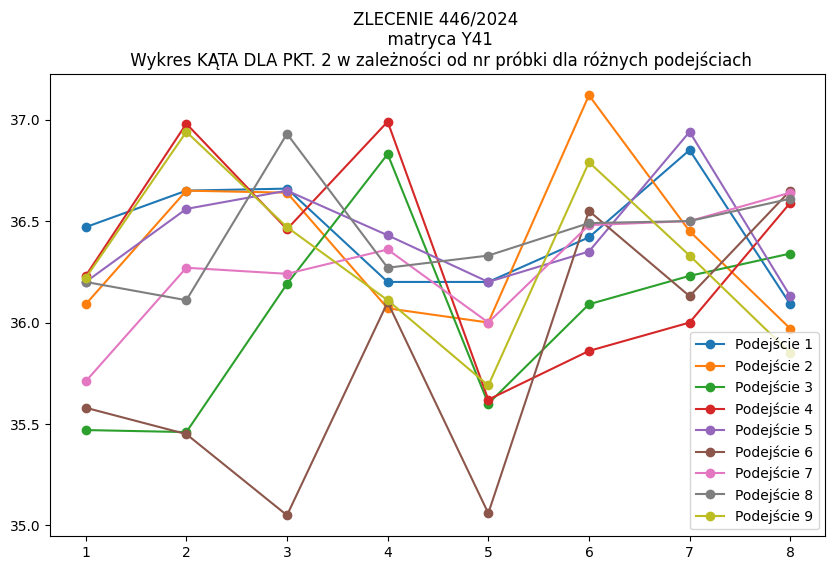

In [24]:
plt.figure(figsize=(10, 6))

plt.plot(filtered_data1['Nr_próbki'], filtered_data1['Kat_Pkt_2'], marker='o', label='Podejście 1')
plt.plot(filtered_data2['Nr_próbki'], filtered_data2['Kat_Pkt_2'], marker='o', label='Podejście 2')
plt.plot(filtered_data3['Nr_próbki'], filtered_data3['Kat_Pkt_2'], marker='o', label='Podejście 3')
plt.plot(filtered_data4['Nr_próbki'], filtered_data4['Kat_Pkt_2'], marker='o', label='Podejście 4')
plt.plot(filtered_data5['Nr_próbki'], filtered_data5['Kat_Pkt_2'], marker='o', label='Podejście 5')
plt.plot(filtered_data6['Nr_próbki'], filtered_data6['Kat_Pkt_2'], marker='o', label='Podejście 6')
plt.plot(filtered_data7['Nr_próbki'], filtered_data7['Kat_Pkt_2'], marker='o', label='Podejście 7')
plt.plot(filtered_data8['Nr_próbki'], filtered_data8['Kat_Pkt_2'], marker='o', label='Podejście 8')
plt.plot(filtered_data9['Nr_próbki'], filtered_data9['Kat_Pkt_2'], marker='o', label='Podejście 9')

# Dodaje legendę
plt.legend()

# Dodaje tytuł
plt.title('ZLECENIE 446/2024 \n  matryca Y41 \n Wykres KĄTA DLA PKT. 2 w zależności od nr próbki dla różnych podejściach')

# Wyświetlam wykres
plt.show()

### Kąt pkt. 3

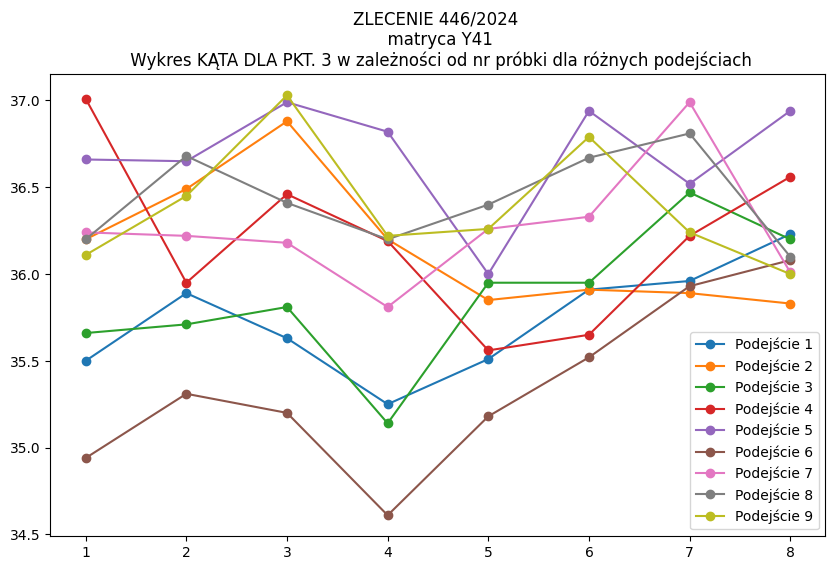

In [25]:
plt.figure(figsize=(10, 6))

plt.plot(filtered_data1['Nr_próbki'], filtered_data1['Kat_Pkt_3'], marker='o', label='Podejście 1')
plt.plot(filtered_data2['Nr_próbki'], filtered_data2['Kat_Pkt_3'], marker='o', label='Podejście 2')
plt.plot(filtered_data3['Nr_próbki'], filtered_data3['Kat_Pkt_3'], marker='o', label='Podejście 3')
plt.plot(filtered_data4['Nr_próbki'], filtered_data4['Kat_Pkt_3'], marker='o', label='Podejście 4')
plt.plot(filtered_data5['Nr_próbki'], filtered_data5['Kat_Pkt_3'], marker='o', label='Podejście 5')
plt.plot(filtered_data6['Nr_próbki'], filtered_data6['Kat_Pkt_3'], marker='o', label='Podejście 6')
plt.plot(filtered_data7['Nr_próbki'], filtered_data7['Kat_Pkt_3'], marker='o', label='Podejście 7')
plt.plot(filtered_data8['Nr_próbki'], filtered_data8['Kat_Pkt_3'], marker='o', label='Podejście 8')
plt.plot(filtered_data9['Nr_próbki'], filtered_data9['Kat_Pkt_3'], marker='o', label='Podejście 9')

# Dodaje legendę
plt.legend()

# Dodaje tytuł
plt.title('ZLECENIE 446/2024 \n  matryca Y41 \n Wykres KĄTA DLA PKT. 3 w zależności od nr próbki dla różnych podejściach')

# Wyświetlam wykres
plt.show()

In [26]:
df['Zlecenie'].unique()

array(['446/2024', '443/2024', '417/2024', '413/2024', '402/2024',
       '355/2024'], dtype=object)

In [27]:
df[df['Zlecenie']=='402/2024']

,Zlecenie,Matryca,Nr_podejścia,Nr_próbki,Wielkość_podejścia_szt,Kat_Pkt_1,Szerokość_mm_Pkt_1,Kat_Pkt_2,Szerokość_mm_Pkt_2,Kat_Pkt_3,Szerokość_mm_Pkt_3,w_tol_Pkt_1,w_tol_Pkt_2,w_tol_Pkt_3
800,402/2024,Y32,1,1,250.0,35.56,8.53,35.87,8.50,36.10,8.52,True,True,True
801,402/2024,Y32,1,2,250.0,35.92,8.51,37.08,8.46,35.56,8.53,True,True,True
802,402/2024,Y32,1,3,250.0,36.25,8.49,35.67,8.50,35.79,8.50,True,True,True
803,402/2024,Y32,1,4,250.0,36.75,8.45,35.76,8.49,36.01,8.49,True,True,True
804,402/2024,Y32,1,5,250.0,36.95,8.45,35.38,8.53,35.71,8.51,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891,402/2024,Y32,12,4,2600.0,35.96,8.47,35.72,8.48,35.42,8.52,True,True,True
892,402/2024,Y32,12,5,2600.0,35.93,8.50,36.02,8.47,35.57,8.53,True,True,True
893,402/2024,Y32,12,6,2600.0,35.45,8.48,36.06,8.45,36.00,8.49,True,True,True
894,402/2024,Y32,12,7,2600.0,35.92,8.47,36.35,8.45,36.21,8.46,True,True,True


# Analiza zlecenia nr 402/2024

# Matryca Y32 / Punkt 1

In [28]:
filtered_data1 = df[(df['Zlecenie'] == '402/2024') & (df['Nr_podejścia'] == 1) & (df['Matryca'] == 'Y32')]
filtered_data2 = df[(df['Zlecenie'] == '402/2024') & (df['Nr_podejścia'] == 2) & (df['Matryca'] == 'Y32')]
filtered_data3 = df[(df['Zlecenie'] == '402/2024') & (df['Nr_podejścia'] == 3) & (df['Matryca'] == 'Y32')]
filtered_data4 = df[(df['Zlecenie'] == '402/2024') & (df['Nr_podejścia'] == 4) & (df['Matryca'] == 'Y32')]
filtered_data5 = df[(df['Zlecenie'] == '402/2024') & (df['Nr_podejścia'] == 5) & (df['Matryca'] == 'Y32')]
filtered_data6 = df[(df['Zlecenie'] == '402/2024') & (df['Nr_podejścia'] == 6) & (df['Matryca'] == 'Y32')]
filtered_data7 = df[(df['Zlecenie'] == '402/2024') & (df['Nr_podejścia'] == 7) & (df['Matryca'] == 'Y32')]
filtered_data8 = df[(df['Zlecenie'] == '402/2024') & (df['Nr_podejścia'] == 8) & (df['Matryca'] == 'Y32')]
filtered_data9 = df[(df['Zlecenie'] == '402/2024') & (df['Nr_podejścia'] == 9) & (df['Matryca'] == 'Y32')]
filtered_data10 = df[(df['Zlecenie'] == '402/2024') & (df['Nr_podejścia'] == 10) & (df['Matryca'] == 'Y32')]
filtered_data11 = df[(df['Zlecenie'] == '402/2024') & (df['Nr_podejścia'] == 11) & (df['Matryca'] == 'Y32')]
filtered_data12 = df[(df['Zlecenie'] == '402/2024') & (df['Nr_podejścia'] == 12) & (df['Matryca'] == 'Y32')]

### Szerokość pkt. 1

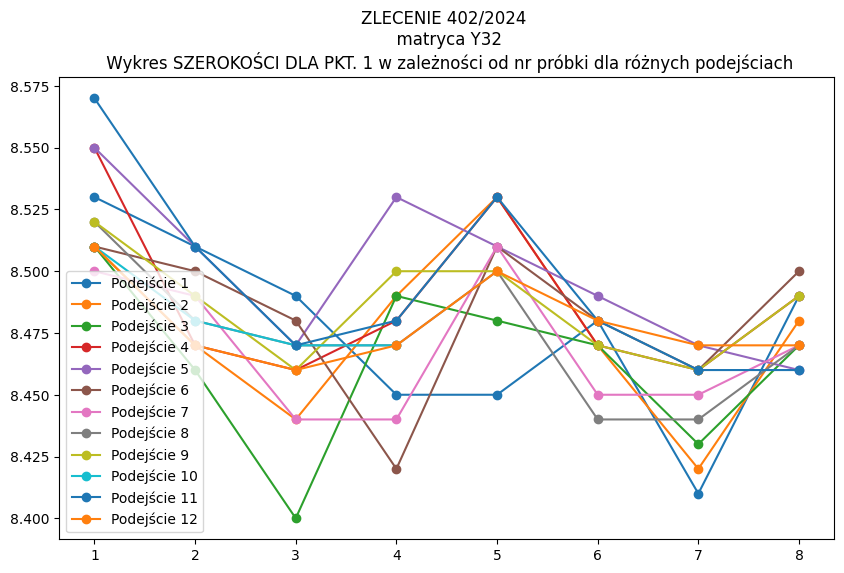

In [29]:
plt.figure(figsize=(10, 6))

plt.plot(filtered_data1['Nr_próbki'], filtered_data1['Szerokość_mm_Pkt_1'], marker='o', label='Podejście 1')
plt.plot(filtered_data2['Nr_próbki'], filtered_data2['Szerokość_mm_Pkt_1'], marker='o', label='Podejście 2')
plt.plot(filtered_data3['Nr_próbki'], filtered_data3['Szerokość_mm_Pkt_1'], marker='o', label='Podejście 3')
plt.plot(filtered_data4['Nr_próbki'], filtered_data4['Szerokość_mm_Pkt_1'], marker='o', label='Podejście 4')
plt.plot(filtered_data5['Nr_próbki'], filtered_data5['Szerokość_mm_Pkt_1'], marker='o', label='Podejście 5')
plt.plot(filtered_data6['Nr_próbki'], filtered_data6['Szerokość_mm_Pkt_1'], marker='o', label='Podejście 6')
plt.plot(filtered_data7['Nr_próbki'], filtered_data7['Szerokość_mm_Pkt_1'], marker='o', label='Podejście 7')
plt.plot(filtered_data8['Nr_próbki'], filtered_data8['Szerokość_mm_Pkt_1'], marker='o', label='Podejście 8')
plt.plot(filtered_data9['Nr_próbki'], filtered_data9['Szerokość_mm_Pkt_1'], marker='o', label='Podejście 9')
plt.plot(filtered_data10['Nr_próbki'], filtered_data10['Szerokość_mm_Pkt_1'], marker='o', label='Podejście 10')
plt.plot(filtered_data11['Nr_próbki'], filtered_data11['Szerokość_mm_Pkt_1'], marker='o', label='Podejście 11')
plt.plot(filtered_data12['Nr_próbki'], filtered_data12['Szerokość_mm_Pkt_1'], marker='o', label='Podejście 12')

# Dodaje legendę
plt.legend()

# Dodaje tytuł
plt.title('ZLECENIE 402/2024 \n  matryca Y32 \n Wykres SZEROKOŚCI DLA PKT. 1 w zależności od nr próbki dla różnych podejściach')

# Wyświetlam wykres
plt.show()

### Szerokość pkt. 2

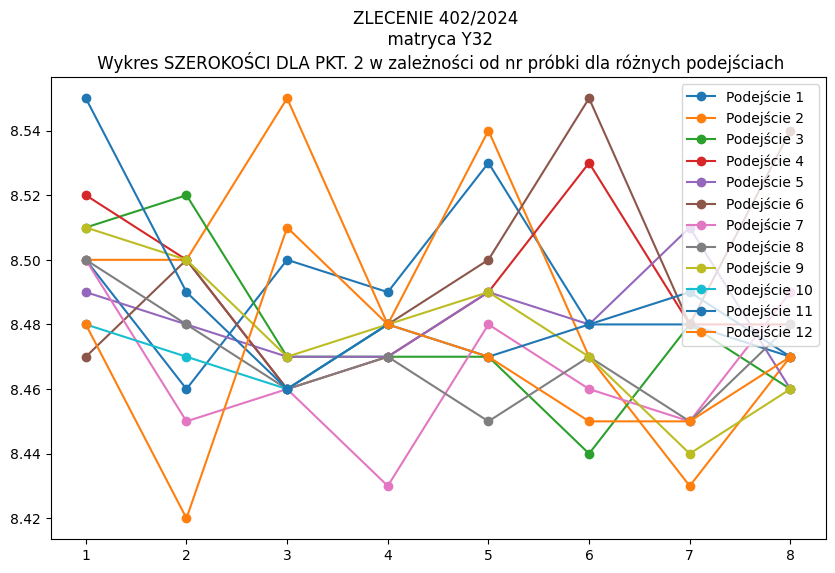

In [30]:
plt.figure(figsize=(10, 6))

plt.plot(filtered_data1['Nr_próbki'], filtered_data1['Szerokość_mm_Pkt_2'], marker='o', label='Podejście 1')
plt.plot(filtered_data2['Nr_próbki'], filtered_data2['Szerokość_mm_Pkt_2'], marker='o', label='Podejście 2')
plt.plot(filtered_data3['Nr_próbki'], filtered_data3['Szerokość_mm_Pkt_2'], marker='o', label='Podejście 3')
plt.plot(filtered_data4['Nr_próbki'], filtered_data4['Szerokość_mm_Pkt_2'], marker='o', label='Podejście 4')
plt.plot(filtered_data5['Nr_próbki'], filtered_data5['Szerokość_mm_Pkt_2'], marker='o', label='Podejście 5')
plt.plot(filtered_data6['Nr_próbki'], filtered_data6['Szerokość_mm_Pkt_2'], marker='o', label='Podejście 6')
plt.plot(filtered_data7['Nr_próbki'], filtered_data7['Szerokość_mm_Pkt_2'], marker='o', label='Podejście 7')
plt.plot(filtered_data8['Nr_próbki'], filtered_data8['Szerokość_mm_Pkt_2'], marker='o', label='Podejście 8')
plt.plot(filtered_data9['Nr_próbki'], filtered_data9['Szerokość_mm_Pkt_2'], marker='o', label='Podejście 9')
plt.plot(filtered_data10['Nr_próbki'], filtered_data10['Szerokość_mm_Pkt_2'], marker='o', label='Podejście 10')
plt.plot(filtered_data11['Nr_próbki'], filtered_data11['Szerokość_mm_Pkt_2'], marker='o', label='Podejście 11')
plt.plot(filtered_data12['Nr_próbki'], filtered_data12['Szerokość_mm_Pkt_2'], marker='o', label='Podejście 12')

# Dodaje legendę
plt.legend()

# Dodaje tytuł
plt.title('ZLECENIE 402/2024 \n  matryca Y32 \n Wykres SZEROKOŚCI DLA PKT. 2 w zależności od nr próbki dla różnych podejściach')

# Wyświetlam wykres
plt.show()

### Szerokość pkt. 3

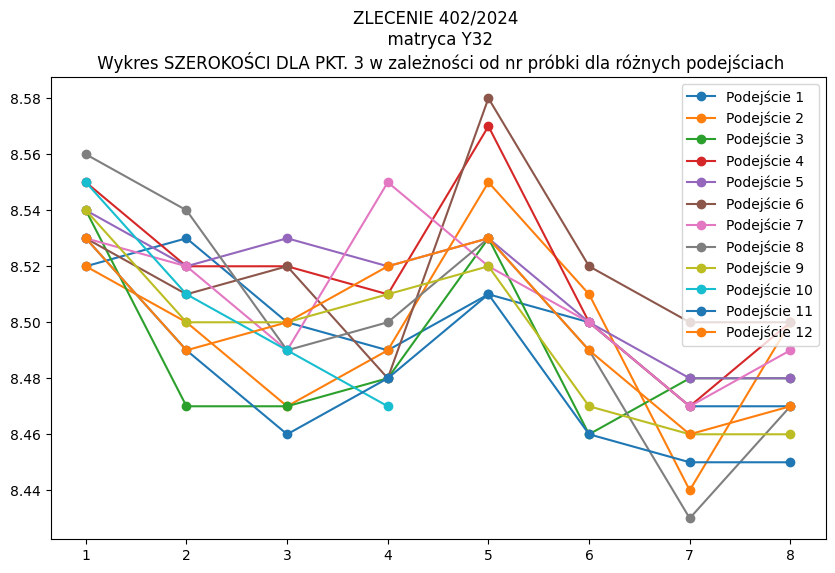

In [31]:
plt.figure(figsize=(10, 6))

plt.plot(filtered_data1['Nr_próbki'], filtered_data1['Szerokość_mm_Pkt_3'], marker='o', label='Podejście 1')
plt.plot(filtered_data2['Nr_próbki'], filtered_data2['Szerokość_mm_Pkt_3'], marker='o', label='Podejście 2')
plt.plot(filtered_data3['Nr_próbki'], filtered_data3['Szerokość_mm_Pkt_3'], marker='o', label='Podejście 3')
plt.plot(filtered_data4['Nr_próbki'], filtered_data4['Szerokość_mm_Pkt_3'], marker='o', label='Podejście 4')
plt.plot(filtered_data5['Nr_próbki'], filtered_data5['Szerokość_mm_Pkt_3'], marker='o', label='Podejście 5')
plt.plot(filtered_data6['Nr_próbki'], filtered_data6['Szerokość_mm_Pkt_3'], marker='o', label='Podejście 6')
plt.plot(filtered_data7['Nr_próbki'], filtered_data7['Szerokość_mm_Pkt_3'], marker='o', label='Podejście 7')
plt.plot(filtered_data8['Nr_próbki'], filtered_data8['Szerokość_mm_Pkt_3'], marker='o', label='Podejście 8')
plt.plot(filtered_data9['Nr_próbki'], filtered_data9['Szerokość_mm_Pkt_3'], marker='o', label='Podejście 9')
plt.plot(filtered_data10['Nr_próbki'], filtered_data10['Szerokość_mm_Pkt_3'], marker='o', label='Podejście 10')
plt.plot(filtered_data11['Nr_próbki'], filtered_data11['Szerokość_mm_Pkt_3'], marker='o', label='Podejście 11')
plt.plot(filtered_data12['Nr_próbki'], filtered_data12['Szerokość_mm_Pkt_3'], marker='o', label='Podejście 12')

# Dodaje legendę
plt.legend()

# Dodaje tytuł
plt.title('ZLECENIE 402/2024 \n  matryca Y32 \n Wykres SZEROKOŚCI DLA PKT. 3 w zależności od nr próbki dla różnych podejściach')

# Wyświetlam wykres
plt.show()

### Kąt pkt. 1

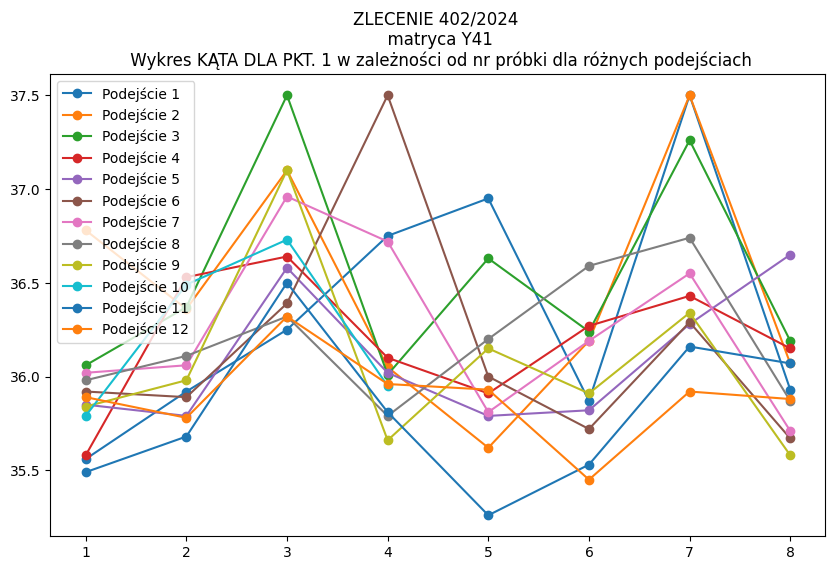

In [32]:
plt.figure(figsize=(10, 6))

plt.plot(filtered_data1['Nr_próbki'], filtered_data1['Kat_Pkt_1'], marker='o', label='Podejście 1')
plt.plot(filtered_data2['Nr_próbki'], filtered_data2['Kat_Pkt_1'], marker='o', label='Podejście 2')
plt.plot(filtered_data3['Nr_próbki'], filtered_data3['Kat_Pkt_1'], marker='o', label='Podejście 3')
plt.plot(filtered_data4['Nr_próbki'], filtered_data4['Kat_Pkt_1'], marker='o', label='Podejście 4')
plt.plot(filtered_data5['Nr_próbki'], filtered_data5['Kat_Pkt_1'], marker='o', label='Podejście 5')
plt.plot(filtered_data6['Nr_próbki'], filtered_data6['Kat_Pkt_1'], marker='o', label='Podejście 6')
plt.plot(filtered_data7['Nr_próbki'], filtered_data7['Kat_Pkt_1'], marker='o', label='Podejście 7')
plt.plot(filtered_data8['Nr_próbki'], filtered_data8['Kat_Pkt_1'], marker='o', label='Podejście 8')
plt.plot(filtered_data9['Nr_próbki'], filtered_data9['Kat_Pkt_1'], marker='o', label='Podejście 9')
plt.plot(filtered_data10['Nr_próbki'], filtered_data10['Kat_Pkt_1'], marker='o', label='Podejście 10')
plt.plot(filtered_data11['Nr_próbki'], filtered_data11['Kat_Pkt_1'], marker='o', label='Podejście 11')
plt.plot(filtered_data12['Nr_próbki'], filtered_data12['Kat_Pkt_1'], marker='o', label='Podejście 12')

# Dodaje legendę
plt.legend()

# Dodaje tytuł
plt.title('ZLECENIE 402/2024 \n  matryca Y41 \n Wykres KĄTA DLA PKT. 1 w zależności od nr próbki dla różnych podejściach')

# Wyświetlam wykres
plt.show()

### Kąt pkt. 2

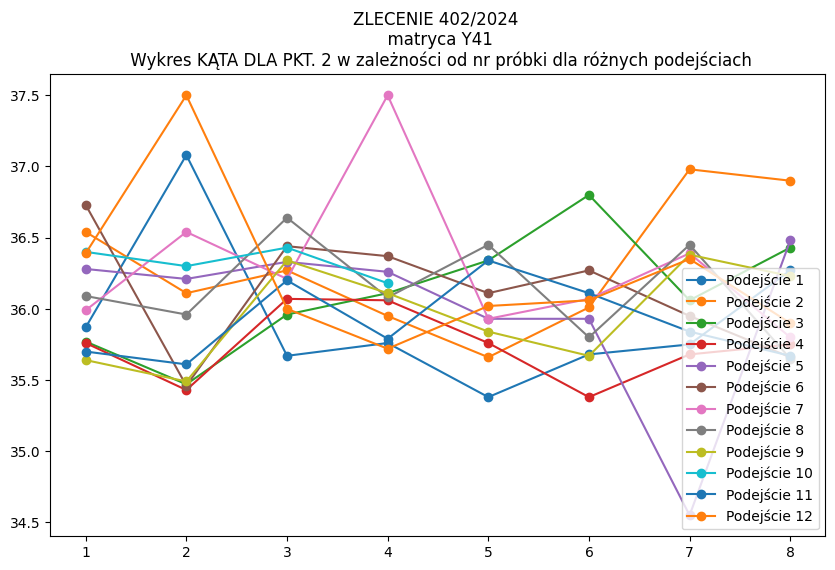

In [33]:
plt.figure(figsize=(10, 6))

plt.plot(filtered_data1['Nr_próbki'], filtered_data1['Kat_Pkt_2'], marker='o', label='Podejście 1')
plt.plot(filtered_data2['Nr_próbki'], filtered_data2['Kat_Pkt_2'], marker='o', label='Podejście 2')
plt.plot(filtered_data3['Nr_próbki'], filtered_data3['Kat_Pkt_2'], marker='o', label='Podejście 3')
plt.plot(filtered_data4['Nr_próbki'], filtered_data4['Kat_Pkt_2'], marker='o', label='Podejście 4')
plt.plot(filtered_data5['Nr_próbki'], filtered_data5['Kat_Pkt_2'], marker='o', label='Podejście 5')
plt.plot(filtered_data6['Nr_próbki'], filtered_data6['Kat_Pkt_2'], marker='o', label='Podejście 6')
plt.plot(filtered_data7['Nr_próbki'], filtered_data7['Kat_Pkt_2'], marker='o', label='Podejście 7')
plt.plot(filtered_data8['Nr_próbki'], filtered_data8['Kat_Pkt_2'], marker='o', label='Podejście 8')
plt.plot(filtered_data9['Nr_próbki'], filtered_data9['Kat_Pkt_2'], marker='o', label='Podejście 9')
plt.plot(filtered_data10['Nr_próbki'], filtered_data10['Kat_Pkt_2'], marker='o', label='Podejście 10')
plt.plot(filtered_data11['Nr_próbki'], filtered_data11['Kat_Pkt_2'], marker='o', label='Podejście 11')
plt.plot(filtered_data12['Nr_próbki'], filtered_data12['Kat_Pkt_2'], marker='o', label='Podejście 12')

# Dodaje legendę
plt.legend()

# Dodaje tytuł
plt.title('ZLECENIE 402/2024 \n  matryca Y41 \n Wykres KĄTA DLA PKT. 2 w zależności od nr próbki dla różnych podejściach')

# Wyświetlam wykres
plt.show()

### Kąt pkt. 3

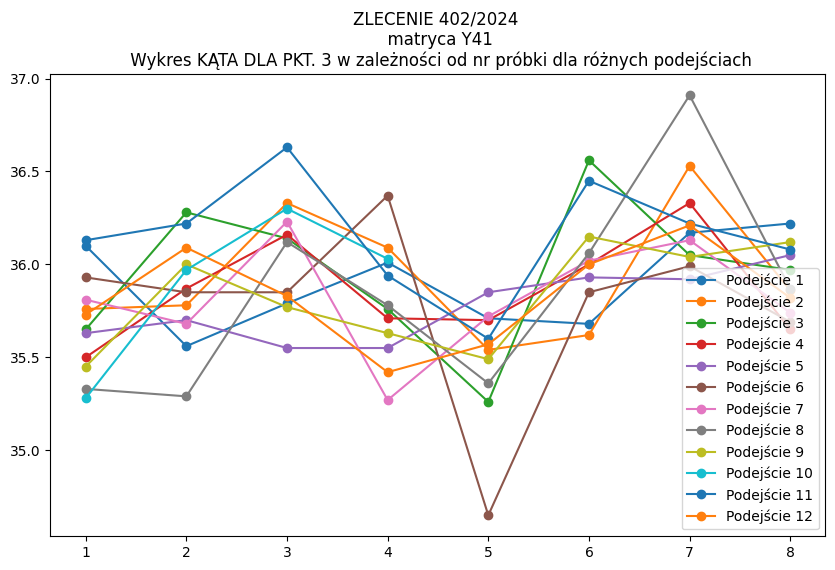

In [34]:
plt.figure(figsize=(10, 6))

plt.plot(filtered_data1['Nr_próbki'], filtered_data1['Kat_Pkt_3'], marker='o', label='Podejście 1')
plt.plot(filtered_data2['Nr_próbki'], filtered_data2['Kat_Pkt_3'], marker='o', label='Podejście 2')
plt.plot(filtered_data3['Nr_próbki'], filtered_data3['Kat_Pkt_3'], marker='o', label='Podejście 3')
plt.plot(filtered_data4['Nr_próbki'], filtered_data4['Kat_Pkt_3'], marker='o', label='Podejście 4')
plt.plot(filtered_data5['Nr_próbki'], filtered_data5['Kat_Pkt_3'], marker='o', label='Podejście 5')
plt.plot(filtered_data6['Nr_próbki'], filtered_data6['Kat_Pkt_3'], marker='o', label='Podejście 6')
plt.plot(filtered_data7['Nr_próbki'], filtered_data7['Kat_Pkt_3'], marker='o', label='Podejście 7')
plt.plot(filtered_data8['Nr_próbki'], filtered_data8['Kat_Pkt_3'], marker='o', label='Podejście 8')
plt.plot(filtered_data9['Nr_próbki'], filtered_data9['Kat_Pkt_3'], marker='o', label='Podejście 9')
plt.plot(filtered_data10['Nr_próbki'], filtered_data10['Kat_Pkt_3'], marker='o', label='Podejście 10')
plt.plot(filtered_data11['Nr_próbki'], filtered_data11['Kat_Pkt_3'], marker='o', label='Podejście 11')
plt.plot(filtered_data12['Nr_próbki'], filtered_data12['Kat_Pkt_3'], marker='o', label='Podejście 12')

# Dodaje legendę
plt.legend()

# Dodaje tytuł
plt.title('ZLECENIE 402/2024 \n  matryca Y41 \n Wykres KĄTA DLA PKT. 3 w zależności od nr próbki dla różnych podejściach')

# Wyświetlam wykres
plt.show()